In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import json
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(style="whitegrid")
from pymongo import MongoClient

# Remember to connect to VPN first 
DATABASE_URL = "internal-mongo-elb-624130134.us-east-1.elb.amazonaws.com"
USER, PWD = 'analyzer', 'hyperpilot'
METRIC_DB, CONFIG_DB = 'metricdb', 'configdb'

In [2]:
# Utilities
def find_all(collection, filt={}, proj=None, database=METRIC_DB, return_list=False):
    """ A wrapper for 'find' to ensure the connection will be closed.
    Args:
        collection(str): mongoDB collection
        filt(dict): mongoDB filter
        proj(dict): mongoDB projection
        database(str): name of database
    Return:
        documents(cursor): mongoDB cursor 
    """
    try:
        client = MongoClient(DATABASE_URL, waitQueueTimeoutMS=200)
        db = client[database]
        db.authenticate(USER, PWD, source=database)
        if proj:
            documents = db[collection].find(filt, proj)
        else:
            documents = db[collection].find(filt)
    except Exception as e:
        raise e
    else:
        return documents if not return_list else list(documents)
    finally:
        client.close()


def find_one(collection, filt, proj=None, database=METRIC_DB):
    """ A wrapper for 'findOne' to ensure the connection will be closed.
    Args:
        collection(str): mongoDB collection
        filt(dict): mongoDB filter
        proj(dict): mongoDB projection
        database(str): name of database
    Return:
        documents(cursor): mongoDB cursor 
    """
    try:
        client = MongoClient(DATABASE_URL, waitQueueTimeoutMS=200)
        db = client[database]
        db.authenticate(USER, PWD, source=database)
        if proj:
            document = db[collection].find_one(filt, proj)
        else:
            document = db[collection].find_one(filt)
    except Exception as e:
        raise e
    else:
        return document
    finally:
        client.close()

In [166]:
def create_application_dataframe():
    app_objs = find_all(collection='applications', database=CONFIG_DB, return_list=True)
    data, columns = [], ['name', 'sloMetric', 'sloValue', 'sloType']
    for i in app_objs:
        data.append([i['name'], i['slo']['metric'], i['slo']['value'], i['slo']['type']])
    return pd.DataFrame(data, columns=columns)

In [167]:
def create_calibration_dataframe():
    cali_objs = find_all(collection='calibration', return_list=True)
    dfs = []
    keys = [set(i.keys()) for i in cali_objs]
    union_keys = reduce(set.intersection, keys)
    union_keys.remove('testResult')

    for cali_obj in cali_objs:
        tmp_df = pd.read_json(json.dumps(cali_obj['testResult']))
        for i in union_keys:            
            tmp_df[i] = np.array(cali_obj[i]).squeeze()
        if 'qos' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qos': 'qosValue'})
        if 'qosMetric' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qosMetric': 'qosValue'})
        if 'intensity' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'intensity': 'loadIntensity'})
        dfs.append(tmp_df)
    df = pd.concat(dfs)
    return df

In [168]:
def create_profiling_dataframe():
    prof_objs = find_all(collection='profiling', return_list=True)
    dfs = []
    keys = [set(i.keys()) for i in prof_objs]
    union_keys = reduce(set.intersection, keys)
    union_keys.remove('testResult')
    union_keys.remove('benchmarks')
    union_keys.remove('services')
    
    for prof_obj in prof_objs:
        tmp_df = pd.DataFrame([pd.Series(i) for i in prof_obj['testResult']])
        if 'toleratedInterference' in tmp_df.columns:
            del tmp_df['toleratedInterference']
        if 'qos' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qos': 'qosValue'})
        if 'qosMetric' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'qosMetric': 'qosValue'})
        if 'intensity' in tmp_df.columns:
            tmp_df = tmp_df.rename(columns={'intensity': 'loadIntensity'})
        for i in union_keys:
            tmp_df[i] = np.array(prof_obj[i]).squeeze()
        dfs.append(tmp_df)
    df = pd.concat(dfs)
    df['appNameCap'] = df['appName'] + df['appCapacity'].map(lambda x : '-cap:'+str(x))
    
    return df


In [169]:
app_df = create_application_dataframe()
app_df

,name,sloMetric,sloValue,sloType
0,redis,GET,35000,throughput
1,mongo,Insert.Empty,5000,throughput
2,mysql,GET,35000,throughput
3,kafka,99thLatency,200,latency
4,nginx,95,300,throughput


In [170]:
cali_df = create_calibration_dataframe()
cali_df.columns

Index([ u'loadIntensity',       u'qosValue',        u'appName',
           u'qosMetrics',     u'loadTester',   u'testDuration',
               u'testId',            u'_id', u'finalIntensity'],
      dtype='object')

In [171]:
prof_df = create_profiling_dataframe()

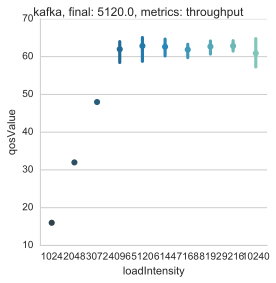

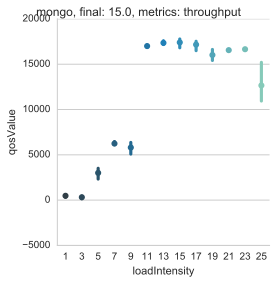

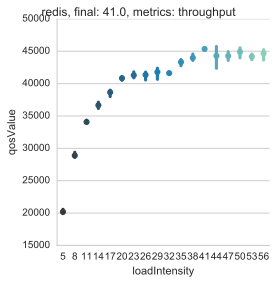

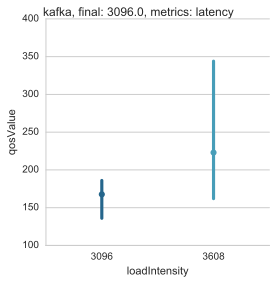

In [172]:
for name, df in cali_df.groupby('testId'):
    g = sns.factorplot(x="loadIntensity", y="qosValue", data=df,
                       palette="YlGnBu_d", ci=100, scale=0.6)
    g.fig.suptitle('{}, final: {}, metrics: {}'.format(df['appName'].values[-1], df['finalIntensity'].values[-1], df['qosMetrics'][0]))

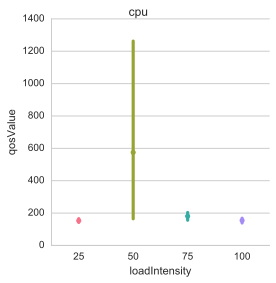

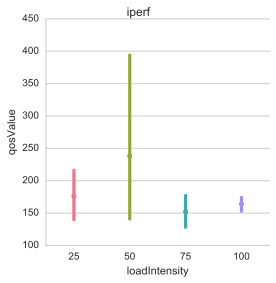

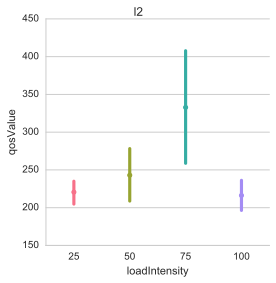

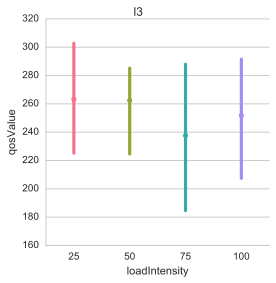

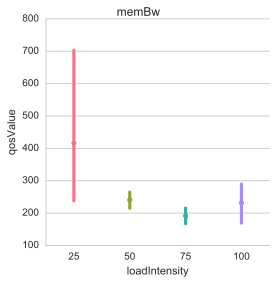

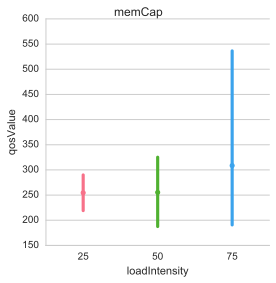

In [200]:
for i, gp in prof_df[prof_df['appName']=='kafka'].groupby('benchmark'):
    g = sns.factorplot(x="loadIntensity", y="qosValue", data=gp,
                   palette="husl", scale=0.5, ci=90)
#     g.fig.suptitle(i[:i.find('-')] +' capacity: {}'.format(i[i.find(':')+1:]))
    g.fig.suptitle('{}'.format(i))
    
# TODO: Add a horizontal bar of 0 interference intensity throughput
# TODO: Compute Tolerated Interference with linear interpolation

    

In [155]:
cali_df

,loadIntensity,qosValue,appName,qosMetrics,loadTester,testDuration,testId,_id,finalIntensity
0,5,20069.00,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0
1,5,20578.00,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0
2,5,19916.00,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0
3,8,28609.00,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0
4,8,28668.00,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0
5,8,29393.00,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0
6,11,33922.00,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0
7,11,34357.00,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0
8,11,33944.00,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0
9,14,37131.00,redis,throughput,redis-bench,23m26.239612823s,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,59406aa9e3fd9e5094db7f3b,41.0


In [176]:
for benchmark, df in prof_df[prof_df['appName'] == 'kafka'].groupby('benchmark'):
    print benchmark
    print df

cpu
   benchmark  loadIntensity  qosValue serviceInTest appName testDuration  \
0        cpu             25     146.0         kafka   kafka                
1        cpu             25     144.0         kafka   kafka                
2        cpu             25     160.0         kafka   kafka                
3        cpu             25     181.0         kafka   kafka                
4        cpu             25     134.0         kafka   kafka                
5        cpu             50     182.0         kafka   kafka                
6        cpu             50     381.0         kafka   kafka                
7        cpu             50     142.0         kafka   kafka                
8        cpu             50    2010.0         kafka   kafka                
9        cpu             50     159.0         kafka   kafka                
10       cpu             75     127.0         kafka   kafka                
11       cpu             75     203.0         kafka   kafka                
12      

In [ ]:
groups = cali_df.groupby('finalIntensity')
for final_intensity, final_intensity_group in groups:
    df = final_intensity_group.groupby('loadIntensity').mean()
    print df.iloc[df.index.map(float) == final_intensity]['qosMetric']

In [ ]:
def compute_tolerated_interference(prof_df):
    print prof_df.groupby('appName')['qos'].min()
     
    print prof_df.groupby('appName')['qos'].max()

compute_tolerated_interference(prof_df)

In [154]:
prof_df

,benchmark,loadIntensity,qosValue,serviceInTest,appName,testDuration,sloTolerance,numServices,appCapacity,loadTester,testId,serviceNode,_id,sloMetric,appNameCap
0,cpu,25,47323.84,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59407070e3fd9e5094db7fb3,,redis-cap:41.0
1,cpu,50,48419.12,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59407070e3fd9e5094db7fb3,,redis-cap:41.0
2,cpu,75,42678.50,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59407070e3fd9e5094db7fb3,,redis-cap:41.0
3,cpu,100,41976.24,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59407070e3fd9e5094db7fb3,,redis-cap:41.0
4,memCap,25,46977.03,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59407070e3fd9e5094db7fb3,,redis-cap:41.0
5,memCap,50,46249.19,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59407070e3fd9e5094db7fb3,,redis-cap:41.0
6,memCap,75,46979.24,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59407070e3fd9e5094db7fb3,,redis-cap:41.0
7,memCap,100,45409.14,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59407070e3fd9e5094db7fb3,,redis-cap:41.0
0,cpu,25,44527.56,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59408164e3fd9e5094db803d,,redis-cap:41.0
1,cpu,25,45810.62,redis,redis,,0.0,1,41.0,redis-bench,calibrate-8e6a8363-1731-4aac-64cc-178ab62f5deb,,59408164e3fd9e5094db803d,,redis-cap:41.0


In [ ]:
# Hacking...
prof_df = prof_df.sort_values('intensity', ascending=True)
tests = prof_df.groupby(['testId', 'benchmark', 'intensity'])['qos'].mean()
tests = pd.DataFrame(tests).reset_index()
reduced = tests.groupby(['testId', 'benchmark'])

dfs = pd.DataFrame(columns=['testId', 'benchmark', 'tolerated interference'])

for idx, (i, j) in enumerate(reduced):
    dfs.loc[idx] = [i[0], i[1], j['qos'].max()-j['qos'].min()]    

feature_names = list(set(dfs['benchmark']))

apps,features = [], []
for i, j in dfs.groupby('testId'):
    apps.append(i)
    feature = []
    for k in feature_names:
        try:
            feature.append(j.loc[j['benchmark'] == k]['tolerated interference'].values[0])
        except:
            feature.append(0)
    features.append(feature)

In [ ]:
feature_names

In [ ]:
import numpy as np
import pylab as pl

class Radar(object):

    def __init__(self, fig, titles, labels, rect=None):
        if rect is None:
            rect = [0.05, 0.05, 0.95, 0.95]

        self.n = len(titles)
        self.angles = np.arange(90, 90+360, 360.0/self.n)
        self.axes = [fig.add_axes(rect, projection="polar", label="axes%d" % i) 
                         for i in range(self.n)]

        self.ax = self.axes[0]
        self.ax.set_thetagrids(self.angles, labels=titles, fontsize=14)

        for ax in self.axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)

        for ax, angle, label in zip(self.axes, self.angles, labels):
            ax.set_rgrids(range(1, 6), angle=angle, labels=label)
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(0, 5)

    def plot(self, values, *args, **kw):
        angle = np.deg2rad(np.r_[self.angles, self.angles[0]])
        values = np.r_[values, values[0]]
        self.ax.plot(angle, values, *args, **kw)
        
fig = pl.figure(figsize=(5,5))

titles = feature_names

labels = [
    ['{}%'.format(i) for i in range(20, 101, 20)]
]*len(feature_names)

import numpy as np
radar = Radar(fig, titles, labels)
for i, j in zip(apps, features):
    print i, j
    radar.plot(np.log10(1+np.array(j)), '-', lw=2, alpha=0.4, label=i)
radar.ax.legend()

In [ ]:
def computeToleratedInterference(benchmarks, sloMetric, metricType, tolerancePercentage=10.):
    """ Compute Tolerated Interference. 
    Assuming monotomicity in between each benchmarks interval. 
    Args: 
        benchmarks(DataFrame): index=intensity and columns=['qos']
        metricType(str): 'throughput', 'latency'
        tolerancePercentage(float): percentage of slo tolerance
    Return:
        ti(float): tolerated interference.
    """
    def _linearIntp((x1,y1), (x2,y2), y3):
        if y1 > y2:
            return _linearIntp((x2,y2),(x1,y1), y3)
        if y3 < y1 or y3 > y2:
            return None
        else:
            return (y3-y1)*(x2-x1)/(y2-y1)+x1
        
    intensities, sloValues = np.append(0, benchmarks.index.values), np.append(sloMetric, benchmarks.values)
    candidates = []
    
    # check metric type
    if metricType == 'throughput':
        toleratedSloMetric = sloMetric * (1.-tolerancePercentage/100.)
        if min(sloValues) > toleratedSloMetric:
            candidates.append(100.)
    elif metricType == 'latency':
        toleratedSloMetric = sloMetric * (1.+tolerancePercentage/100.)
        if max(sloValues) < toleratedSloMetric:
            candidates.append(100.)
    else:
        assert False, 'invalid metric type'
    print 'type: {}'.format(metricType), 'toleratedMetric: {}'.format(toleratedSloMetric)

    # check input data
    assert (sorted(intensities) == intensities).all(), 'intensities are not monotonic. intensities: {}'.format(intensities)
    assert all(intensity >= 0 and intensity <= 100 for intensity in intensities), 'invalid intensities. intensites: {}'.format(intensities)
    assert len(sloValues) == len(intensities), 'length of sloValues and intensities does not match. sloValues: {}, intensities: {}'.format(sloValues, intensities)

    for i in range(len(sloValues)-1): # edge case tested
        x = _linearIntp((intensities[i], sloValues[i]), (intensities[i+1], sloValues[i+1]), toleratedSloMetric)
        if x:
            candidates.append(x)
    
    return sorted(candidates)

In [ ]:
# computeToleratedInterference Test data
testData = []
for i,j in prof_df.groupby('appName'):
    print i # will need to go back to config.applications to find out the type of metric. 
    k = j.groupby('intensity')['qos'].mean()
    print k
    testData.append(k)

In [ ]:
# normal case
sloMetric = 10000.
print 'input data:', testData[0]
output = computeToleratedInterference(testData[0], sloMetric, 'throughput', tolerancePercentage=10)
print 'output:', output

sloMetric = 48000.
print 'input data:', testData[1]
output = computeToleratedInterference(testData[1], sloMetric, 'throughput', tolerancePercentage=10)
print 'output:', output

# out of bound
sloMetric = 45000.
print 'input data:', testData[1]
output = computeToleratedInterference(testData[1], sloMetric, 'throughput', tolerancePercentage=10)
print 'output:', output

# multiple results?